<a href="https://colab.research.google.com/github/serawit/serawit/blob/main/Final__Coffee_Plant_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount drive (Connecting to google drive)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import libraries/packages

In [ ]:
import os
import numpy as np
import cv2 as cv
import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

# dataset splitter (as train/val/test)
from sklearn.model_selection import train_test_split

# for the ML/DL models
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

from tensorflow.keras import metrics

## Image dataset filepath

In [ ]:
# Specify the path to the directory containing your images

healthy_dir_path = '/content/drive/MyDrive/CoffeeLeaf_images/Healthy'
miner_dir_path = '/content/drive/MyDrive/CoffeeLeaf_images/Miner'
rust_dir_path = '/content/drive/MyDrive/CoffeeLeaf_images/Rust'
phoma_dir_path = '/content/drive/MyDrive/CoffeeLeaf_images/Phoma'
cersco_dir_path = '/content/drive/MyDrive/CoffeeLeaf_images/Cerscospora'

# Image loading

In [ ]:
def load_images_from_folder(folder_path, label, max_images=1000):
    images = []
    labels = []
    count = 0
    for filename in os.listdir(folder_path):
        if count >= max_images:
            break
        img = cv.imread(os.path.join(folder_path,filename))
        if img is not None:
            images.append(img)
            labels.append(label)
            count += 1
    return images, labels

In [ ]:
# Load images from folders
healthy_images, healthy_labels = load_images_from_folder(healthy_dir_path, 0)
miner_images, miner_labels = load_images_from_folder(miner_dir_path, 1)
rust_images, rust_labels = load_images_from_folder(rust_dir_path, 2)
phoma_images, phoma_labels = load_images_from_folder(phoma_dir_path, 3)
cersco_images, cersco_labels = load_images_from_folder(cersco_dir_path, 4)

In [ ]:
# Combine the data
all_images = healthy_images + miner_images + rust_images + phoma_images + cersco_images
all_labels = healthy_labels + miner_labels + rust_labels + phoma_labels + cersco_labels

# Split the data into training, validation and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(all_images, all_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
def summarize_dataset(X, y, name):
  num_samples = len(X)
  num_classes = len(np.unique(y))
  print(f"Dataset: {name}")
  print(f"  Number of samples: {num_samples}")
  print(f"  Number of classes: {num_classes}")
  print(f"  Class distribution: {np.bincount(y)}")
  print()

# Summarize each dataset
summarize_dataset(X_train, y_train, "Training")
summarize_dataset(X_val, y_val, "Validation")
summarize_dataset(X_test, y_test, "Testing")

Dataset: Training
  Number of samples: 3500
  Number of classes: 5
  Class distribution: [684 691 716 699 710]

Dataset: Validation
  Number of samples: 750
  Number of classes: 5
  Class distribution: [159 148 142 148 153]

Dataset: Testing
  Number of samples: 750
  Number of classes: 5
  Class distribution: [157 161 142 153 137]



# Feature extraction

### Edge feature with Canny algorithm

In [ ]:
def extract_canny_edges(image, low_threshold=50, high_threshold=150, target_size=(128, 128)):
    """
    Extracts Canny edges from a grayscale image and resizes them to a consistent size.

    Args:
        image: A grayscale image.
        low_threshold: Lower threshold for Canny edge detection.
        high_threshold: Upper threshold for Canny edge detection.
        target_size: Tuple specifying the desired width and height of the output edge image.

    Returns:
        A flattened numpy array of edge features with a consistent shape.
    """
    edges = cv.Canny(image, low_threshold, high_threshold)
    resized_edges = cv.resize(edges, target_size) # Resize edges to a fixed size
    return resized_edges.flatten()

### Color feature with histogram

In [ ]:
def extract_color_histogram(image, bins=(8, 8, 8)):
       """Extracts a color histogram from an image."""
       hsv_image = cv.cvtColor(image, cv.COLOR_BGR2HSV)
       hist = cv.calcHist([hsv_image], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
       hist = cv.normalize(hist, hist).flatten()
       return hist

### Combining features

In [ ]:
X_train_combined = [np.concatenate((extract_canny_edges(img), extract_color_histogram(img))) for img in X_train]
X_val_combined = [np.concatenate((extract_canny_edges(img), extract_color_histogram(img))) for img in X_val]
X_test_combined = [np.concatenate((extract_canny_edges(img), extract_color_histogram(img))) for img in X_test]

# Model training

### SVM

In [ ]:
def train_svm(X_train, y_train, X_val, y_val):
    """
    Trains an SVM model using the provided training and validation data.

    Args:
        X_train: Training features.
        y_train: Training labels.
        X_val: Validation features.
        y_val: Validation labels.

    Returns:
        A trained SVM model.
    """
    # Create an SVM classifier
    clf = svm.SVC()

    # Train the model
    clf.fit(X_train, y_train)

    # Evaluate on validation set (optional, but recommended)
    val_accuracy = clf.score(X_val, y_val)
    print("Validation Accuracy:", val_accuracy)

    return clf

In [ ]:
model_svm = train_svm(X_train_combined, y_train, X_val_combined, y_val)

Validation Accuracy: 0.9866666666666667


### KNN

In [ ]:
def train_knn(X_train, y_train, X_val, y_val, k=5):
    """
    Trains a k-Nearest Neighbors model using the provided training and validation data.

    Args:
        X_train: Training features.
        y_train: Training labels.
        X_val: Validation features.
        y_val: Validation labels.
        k: Number of neighbors to consider (default is 5 (6/4)).

    Returns:
        A trained k-NN model.
    """

    # Convert one-hot encoded labels to integer labels (if any?)
    #y_train = np.argmax(y_train, axis=1)
    #y_val = np.argmax(y_val, axis=1)

    # Create a k-NN classifier
    clf = KNeighborsClassifier(n_neighbors=k)

    # Train the model
    clf.fit(X_train, y_train)

    # Evaluate on validation set (optional, but recommended)
    val_accuracy = clf.score(X_val, y_val)
    print("Validation Accuracy:", val_accuracy)

    return clf

In [ ]:
model_knn = train_knn(X_train_combined, y_train, X_val_combined, y_val)

Validation Accuracy: 0.7666666666666667


## CNN

### More preprocessing for CNN

In [ ]:
def preprocess_image(image, target_size=(128, 128)):
    """Preprocesses a single image."""
    # skip resizing if got the right size/or if already applied
    image = tf.image.resize(image, target_size)
    image = image / 255.0  # Normalize pixel values to 0-1
    return image

In [ ]:
# Apply preprocessing to your datasets
X_train_preprocessed = [preprocess_image(img) for img in X_train]
X_val_preprocessed = [preprocess_image(img) for img in X_val]
X_test_preprocessed = [preprocess_image(img) for img in X_test]

# Convert to NumPy arrays
X_train_preprocessed = np.array(X_train_preprocessed)
X_val_preprocessed = np.array(X_val_preprocessed)
X_test_preprocessed = np.array(X_test_preprocessed)

In [ ]:
y_test = np.array(y_test)

In [ ]:
# Assuming y_train and y_val contain integer class labels (0 to 4)

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=5)
y_test_cnn = tf.keras.utils.to_categorical(y_test, num_classes=5)

### Define the CNN model

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X_train_preprocessed.shape[1:]),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')  # For multi-class classification
    #Dense(1, activation='sigmoid')  # For binary classification
])


### Compile & train

In [ ]:
# compile --> train
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Loss for multi-class
              metrics=['accuracy',
                       metrics.Precision(),
                       metrics.Recall(),
                       metrics.AUC()])

model.fit(X_train_preprocessed, y_train, epochs=10,
          validation_data=(X_val_preprocessed, y_val))

Epoch 1/10
110/110 [==============================] - 95s 854ms/step - loss: 0.7472 - accuracy: 0.7277 - precision_2: 0.8395 - recall_2: 0.6249 - auc_2: 0.9330 - val_loss: 0.3011 - val_accuracy: 0.8947 - val_precision_2: 0.9040 - val_recall_2: 0.8787 - val_auc_2: 0.9878
Epoch 2/10
110/110 [==============================] - 109s 995ms/step - loss: 0.2006 - accuracy: 0.9320 - precision_2: 0.9425 - recall_2: 0.9180 - auc_2: 0.9950 - val_loss: 0.1048 - val_accuracy: 0.9720 - val_precision_2: 0.9731 - val_recall_2: 0.9640 - val_auc_2: 0.9988
Epoch 3/10
110/110 [==============================] - 96s 870ms/step - loss: 0.0849 - accuracy: 0.9726 - precision_2: 0.9770 - recall_2: 0.9700 - auc_2: 0.9991 - val_loss: 0.2041 - val_accuracy: 0.9240 - val_precision_2: 0.9258 - val_recall_2: 0.9147 - val_auc_2: 0.9939
Epoch 4/10
110/110 [==============================] - 98s 894ms/step - loss: 0.0588 - accuracy: 0.9846 - precision_2: 0.9857 - recall_2: 0.9831 - auc_2: 0.9994 - val_loss: 0.0223 - val_a

## Comparing the models

In [ ]:
def compare_models(svm_accuracy, knn_accuracy, cnn_accuracy):
    """
    Compares the accuracy of SVM and k-NN models using a bar chart.

    Args:
        svm_accuracy: Accuracy of the SVM model.
        knn_accuracy: Accuracy of the k-NN model.
    """
    models = ['SVM', 'k-NN', 'CNN']
    accuracies = [svm_accuracy, knn_accuracy, cnn_accuracy]

    # Create bar chart
    plt.bar(models, accuracies)

    # Add labels, title, and y-axis limits
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    #plt.title('Comparison of SVM and k-NN Accuracy')
    plt.ylim([0, 1])

    # Display accuracy values on top of bars
    for i, v in enumerate(accuracies):
        plt.text(i, v + 0.01, f"{v:.2f}", ha='center')

    # Show the chart
    plt.show()

In [ ]:
# Assuming you have trained SVM and k-NN models and evaluated them on a test set
# Replace these with your actual accuracy values
svm_test_accuracy = model_svm.score(X_test_combined, y_test)
knn_test_accuracy = model_knn.score(X_test_combined, y_test)
#test_loss, cnn_accuracy = model.evaluate(X_test_preprocessed, y_test_cnn)

In [ ]:
# Evaluate the CNN model
evaluation_results = model.evaluate(X_test_preprocessed, y_test_cnn)

# Extract loss and accuracy
test_loss = evaluation_results[0]
cnn_accuracy = evaluation_results[1]

24/24 [==============================] - 5s 198ms/step - loss: 0.0054 - accuracy: 0.9987 - precision_2: 0.9987 - recall_2: 0.9987 - auc_2: 1.0000


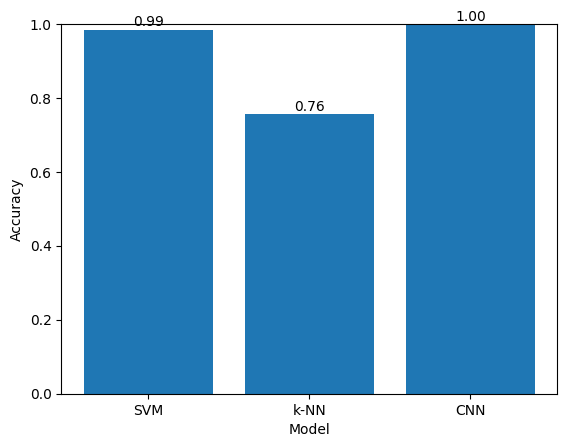

In [ ]:
# Call the function to compare the models
compare_models(svm_test_accuracy, knn_test_accuracy, cnn_accuracy)

<ipython-input-85-86a58d4e1ef9>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


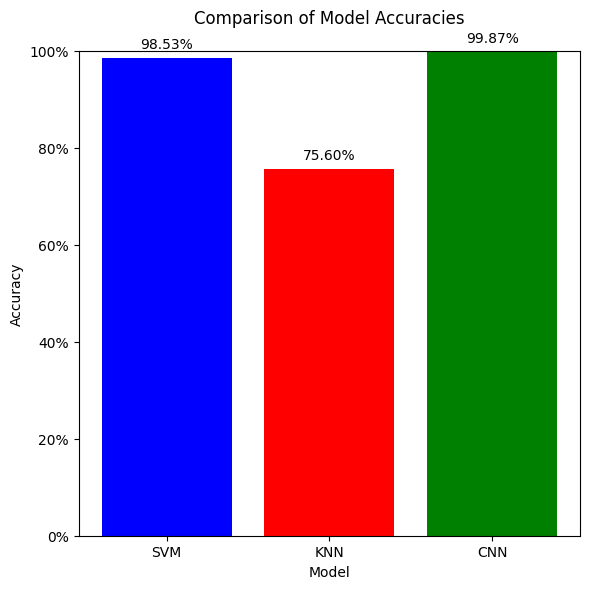

<Figure size 640x480 with 0 Axes>

In [ ]:
models = ['SVM', 'KNN', 'CNN']
accuracies = [svm_test_accuracy, knn_test_accuracy, cnn_accuracy]

colors = ['blue', 'red', 'green']

plt.figure(figsize=(6, 6))  # Adjust figure size for more space

plt.bar(models, accuracies, color=colors)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies', pad=20)  # Add padding to the title

plt.ylim([0, 1])

for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v*100:.2f}%", ha='center')  # Adjust text position

# Format y-axis labels as percentages
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

plt.savefig('model_accuracies.png')  # Save the plot as 'model_accuracies.png'

### Confusion matrix (with heatmap)

In [ ]:
# For SVM
y_pred_svm = model_svm.predict(X_test_combined)
print(classification_report(y_test, y_pred_svm))
print(confusion_matrix(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       157
           1       0.97      0.97      0.97       161
           2       1.00      0.99      1.00       142
           3       0.97      0.97      0.97       153
           4       0.98      1.00      0.99       137

    accuracy                           0.99       750
   macro avg       0.99      0.99      0.99       750
weighted avg       0.99      0.99      0.99       750

[[156   0   0   0   1]
 [  0 156   0   4   1]
 [  0   0 141   0   1]
 [  0   4   0 149   0]
 [  0   0   0   0 137]]


In [ ]:
# For KNN
y_pred_knn = model_knn.predict(X_test_combined)
print(classification_report(y_test, y_pred_knn))
print(confusion_matrix(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       157
           1       0.77      0.53      0.63       161
           2       0.49      1.00      0.66       142
           3       1.00      0.34      0.51       153
           4       0.93      0.96      0.94       137

    accuracy                           0.76       750
   macro avg       0.84      0.76      0.75       750
weighted avg       0.84      0.76      0.74       750

[[156   0   1   0   0]
 [  0  86  74   0   1]
 [  0   0 142   0   0]
 [  0  25  67  52   9]
 [  0   1   5   0 131]]


In [ ]:
# Predict probabilities
y_pred_proba_cnn = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred_cnn = np.argmax(y_pred_proba_cnn, axis=1)

# Calculate confusion matrix
print(confusion_matrix(y_test, y_pred_cnn))

24/24 [==============================] - 7s 314ms/step
[[157   0   0   0   0]
 [  0 161   0   0   0]
 [  0   0 142   0   0]
 [  0   1   0 152   0]
 [  0   0   0   0 137]]


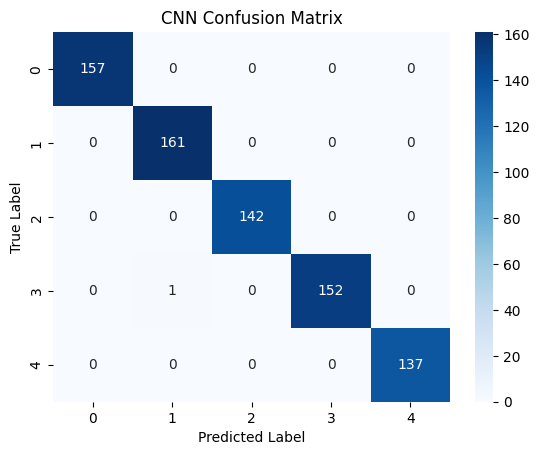

In [ ]:
plt.figure()
sns.heatmap(confusion_matrix(y_test, y_pred_cnn), annot=True, fmt='d', cmap='Blues')
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

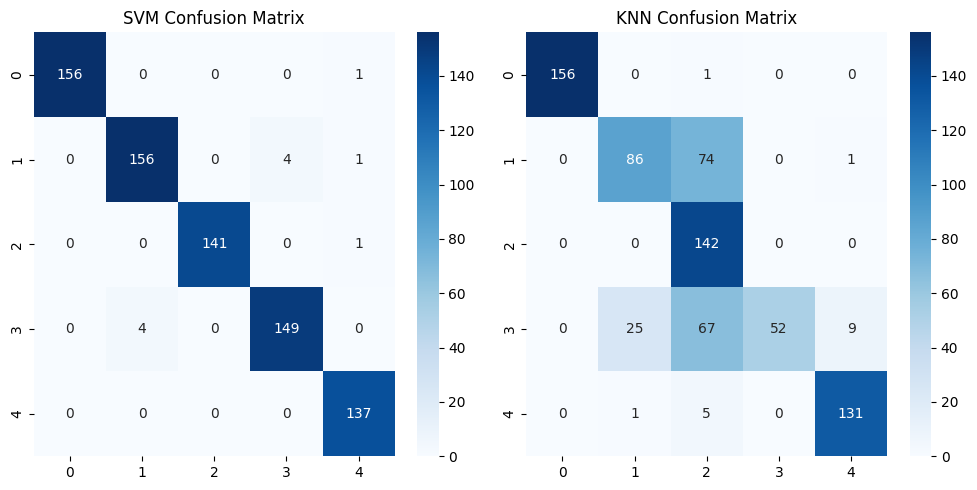

In [ ]:
# Plot confusion matrices
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues')
plt.title('SVM Confusion Matrix')

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='d', cmap='Blues')
plt.title('KNN Confusion Matrix')

plt.tight_layout()
plt.show()